# 「異常検知と変化検知 （機械学習プロフェッショナルシリーズ）」第1章
書籍URL
http://ide-research.net/book/support.html#kodansha


In [2]:
# importや諸々準備
import numpy as np
import pandas as pd
import numpy.random as rd
import scipy.stats as st
from scipy.stats import gaussian_kde
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import animation as ani
plt.style.use('ggplot')
plt.rc('text', usetex=True)

import sys
import sklearn.metrics as mt

rd.seed(7)

# データから分布を生成
def get_density(data, xx, bw=.25):
    density = gaussian_kde(data)
    density.covariance_factor = lambda : bw
    density._compute_covariance()
    return density(xx)

## 図 1.1 時系列データの様々な異常の例 の描画

(199,)


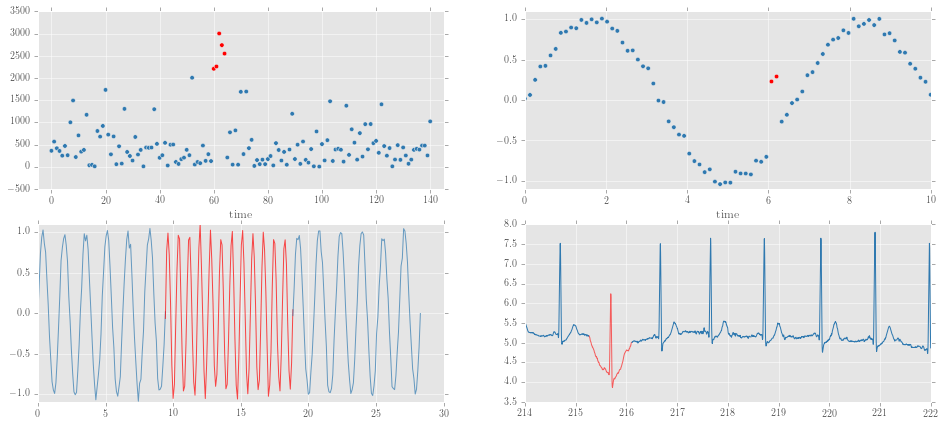

In [182]:
# 図 1.1
n_row = 2    # グラフの行数
n_col = 2    # グラフの列数

plt.subplots(n_row, n_col, figsize=(16,7)) 
gs = gridspec.GridSpec(n_row, n_col)

axs = [plt.subplot(gs[i]) for i in range(4) ]

# 1つ目のエリア描画
rd.seed(0)
n = 141            # データ数
x = np.linspace(0,140,n)
y = rd.exponential(1.5, n) * 300
col = ["#2F79B0" for _ in range(n)] 
for i in range(5):    
    y[60+i] = rd.exponential(1.5, 1) * 300 + 2000
    col[60+i] = "r"
axs[0].scatter(x,y, c=col)
axs[0].set_xlim(-5,145)
axs[0].set_xlabel('time',size=12)


# 2つ目のエリア描画
n=80
xx = np.linspace(0, 3*np.pi, n)
x = np.linspace(0,10,n)
y = np.sin(xx) + rd.normal(0, 0.05, n)
col = ["#2F79B0" for _ in range(n)] 
for i in range(2):    
    y[48+i] += + 0.7
    col[48+i] = "r"
axs[1].scatter(x,y, c=col)
axs[1].set_xlim(0,10)
axs[1].set_ylim(-1.1,1.1)
axs[1].set_xlabel('time',size=12)


# 3つ目のエリア描画
x = None
y = None
n = 90


for i in range(3):
    x = np.linspace((3*i)*np.pi,(3*(i+1))*np.pi,100)
    a = 4 if i != 1 else 8
    y = np.sin(a*x) + rd.normal(0, 0.05, 100)
    
    c = "#2F79B0" if i != 1 else "r" 
    axs[2].plot(x, y, c=c, alpha=0.7)

axs[2].set_xlim(0,30)
axs[2].set_ylim(-1.1, 1.1)

    
# 4つ目のエリア描画
# 心電図データは下記より取得してください。
# http://vivonoetics.com/support/data-files/
# [Compact CSV sample import file](http://vivonoetics.com/wp-content/downloads/download.php?file=Csv_Sample_File_Compact.csv)よりDL
ecg = np.array(pd.read_csv("Csv_Sample_File_Compact.csv").ECG[1100:3000])
ecg = ecg/100.
x = np.linspace(214, 222, len(ecg))

axs[3].plot(x[0:300], ecg[0:300], c="#2F79B0")

x2 = np.linspace(-1,1,199)
x2 = np.linspace(-1,1,199)
y2 = .2*x2**2 +.8
print x[301:500].shape

axs[3].plot(x[301:500], ecg[301:500]*y2, c="r", alpha=.6)
axs[3].plot(x[501:], ecg[501:], c="#2F79B0")

#plt.subplots_adjust()

## 図1.2 ラベル付きデータについての異常判定の説明

mark: 109.704589844
tau pos: 1828
tau: -0.000555726548711
tau2_pos: 3810
tau2: 0.00191532290495
mark2: 228.645729146


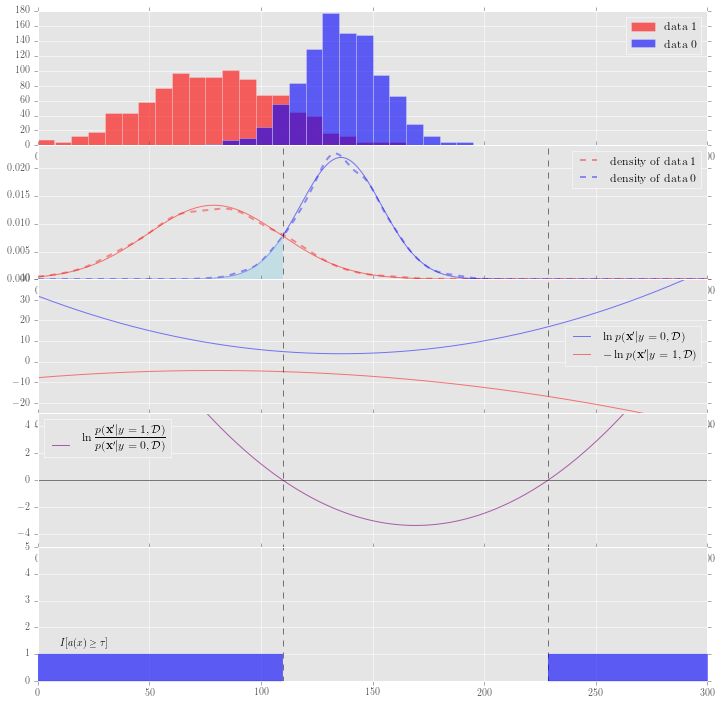

In [5]:
# 乱数生成
rd.seed()
n = 1000
d_0 = rd.normal(135, 18, n)  # 正常データ
d_1 = rd.normal(80, 30, n)   # 異常データ

# 平均、標準偏差の算出
m_0  = np.mean(d_0)
sd_0 = np.sqrt(np.var(d_0))
m_1  = np.mean(d_1)
sd_1 = np.sqrt(np.var(d_1))

# X軸データ生成
xx = np.linspace(0,300, 5000)

# 正規分布の密度関数
density_0 = st.norm.pdf(xx, m_0, sd_0)
density_1 = st.norm.pdf(xx, m_1, sd_1)

# 異常度の計算
abnormaly_score = np.log(density_1) - np.log(density_0)

#---------------- 描画処理 -----------------#
n_row = 5                         # グラフの行数

plt.subplots(n_row, 1, sharex=True,figsize=(12,12)) 
gs = gridspec.GridSpec(n_row, 1, height_ratios=[3,3,3,3,3])

axs = [plt.subplot(gs[i]) for i in range(n_row) ]

# 1つ目のエリア描画
axs[0].hist(d_1, bins=40, color="r", alpha=0.6, range=(0,300), label="data 1")
axs[0].hist(d_0, bins=40, color="b", alpha=0.6, range=(0,300), label="data 0")
axs[0].legend(loc='best')

# 2つ目のエリア描画
axs[1].plot(xx, get_density(d_1, xx), "r--", alpha=.4 , lw=2, label=r"density of data 1")
axs[1].plot(xx, get_density(d_0, xx), "b--", alpha=.4 , lw=2, label=r"density of data 0")
axs[1].legend(loc='best')

def balance_position(x_min, x_max, f1, f2, EPS=0.00001):
    if abs(f1(x_max) - f2(x_max)) > EPS:
        center = (x_min + x_max)/2.
        if np.sign(f1(x_max) - f2(x_max)) * np.sign(f1(center) - f2(center)) < 0:
            x_min = center
        else:
            x_max = center
        x_max = balance_position(x_min, x_max, f1, f2)
    else:
        return x_max
    return x_max
    
mark = balance_position(0, 200, lambda x:st.norm.pdf(x, m_0, sd_0), lambda x: st.norm.pdf(x, m_1, sd_1)) 
print "mark:", mark

tau_pos = np.argsort(np.abs(xx - mark))[0]
print "tau pos:", tau_pos

tau = abnormaly_score[tau_pos]
print "tau:", tau

tau2_pos = np.max(np.argsort(np.abs(abnormaly_score - tau))[0:2])
print "tau2_pos:",tau2_pos

tau2 = abnormaly_score[tau2_pos]
print "tau2:",tau2

mark2 = xx[tau2_pos]
print "mark2:",mark2

axs[1].plot([0,300],[0,0],"k")
axs[1].plot(xx, density_1, c="r", alpha=.5 )
axs[1].plot(xx, density_0, c="b", alpha=.5 )
axs[1].fill_between(xx[0:tau_pos], density_0[0:tau_pos], color="lightblue", zorder = 500, alpha=.6)
axs[1].set_ylim(0,np.max(density_0)*1.1)
axs[1].plot([mark ,mark],[-100,200], "k--", lw=.5)
axs[1].plot([mark2 ,mark2],[-100,200], "k--", lw=.5)

# 3つ目のエリア描画
axs[2].plot(xx, -np.log(density_0), c="b", alpha=.5,  label=r"$\ln p({\bf x}'|y=0,\mathcal{D})$")
axs[2].plot(xx,  np.log(density_1), c="r", alpha=.5, label=r"$-\ln p({\bf x}'|y=1,\mathcal{D})$")
axs[2].plot([mark ,mark],[-110,200], "k--", lw=.5)
axs[2].plot([mark2 ,mark2],[-110,200], "k--", lw=.5)
axs[2].set_ylim(-25,40)
axs[2].legend(loc='best')
    
# 4つ目のエリア描画
axs[3].plot(xx, abnormaly_score, c="purple", alpha=.6, label=r"$$ \ln{ p({\bf x}'|y=1,\mathcal{D})\over  p({\bf x}'|y=0,\mathcal{D})} $$")
axs[3].set_ylim(-5,5)
axs[3].plot([mark ,mark],[-100,200], "k--", lw=.5)
axs[3].plot([mark2 ,mark2],[-100,200], "k--", lw=.5)
axs[3].plot([0 ,300],[tau, tau], "k", lw=.5)
axs[3].legend(loc='best')

# 5つ目のエリア描画
axs[4].fill_between(xx[0:tau_pos], np.ones_like(xx[0:tau_pos]), color="blue", zorder = 500, alpha=.6)
axs[4].fill_between(xx[tau2_pos:], np.ones_like(xx[tau2_pos:]), color="blue", zorder = 500, alpha=.6)
axs[4].plot([mark, mark],[-110,200], "k--", lw=.5)
axs[4].plot([mark2, mark2],[-110,200], "k--", lw=.5)
axs[4].text(10, 1.3, r"$I[a(x) \ge \tau]$")
axs[4].set_ylim(0,5)

# すべてのエリアでxの範囲を固定
for ax in axs:
    ax.set_xlim(0,300)

plt.subplots_adjust(hspace=0)

## # 図1.3 ラベルなしデータについての異常度の定義

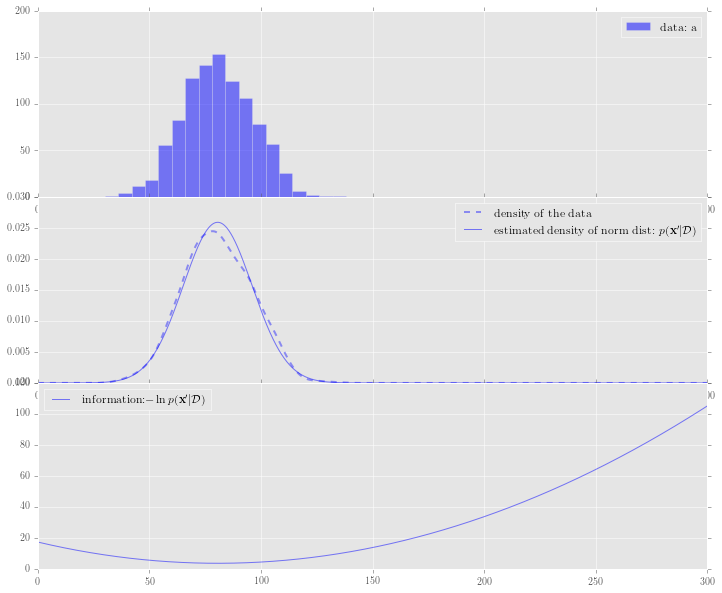

In [37]:
# ラベルなしデータの場合
# 乱数生成
n = 1000
data = rd.normal(80, 15, n)

# 平均、標準偏差の算出
m  = np.mean(data)
sd = np.sqrt(np.var(data))

# X軸データ生成
xx = np.linspace(0,300, 5000)

# 正規分布の密度関数
density = st.norm.pdf(xx, m, sd)

#---------------- 描画処理 -----------------#
n_row = 3                         # グラフの行数
xx = np.linspace(0,300, 5000)     # X軸データ生成

plt.subplots(n_row, 1, sharex=True,figsize=(12,10)) 
gs = gridspec.GridSpec(n_row, 1, height_ratios=[3,3,3])

axs = [plt.subplot(gs[i]) for i in range(n_row) ]

# 1つ目のエリア描画
axs[0].hist(data, bins=50, range=(0,300), label="data: a", color="b", alpha=0.5)
axs[0].set_ylim(0,200)
axs[0].legend(loc='best')

# 2つ目のエリア描画
axs[1].plot(xx, get_density(data, xx), lw=2, linestyle="--", label="density of the data", color="b", alpha=0.4)
axs[1].plot(xx, density, lw=1, label=r"estimated density of norm dist: $p({\bf x}'|\mathcal{D})$", color="b", alpha=0.5)
axs[1].legend(loc='best')

# 3つ目のエリア描画
axs[2].plot(xx, -np.log(density), lw=1, label=r"information:$-\ln p({\bf x}'|\mathcal{D})$", color="b", alpha=0.5)
axs[2].legend(loc='best')


# すべてのエリアでxの範囲を固定
for ax in axs:
    ax.set_xlim(0,300)

plt.subplots_adjust( hspace=0)

## 図1.4, 図1.5 正常標本精度、異常標本精度とROC曲線


0%, 0%, 2%, 4%, 6%, 8%, 10%, 12%, 14%, 16%, 18%, 20%, 22%, 24%, 26%, 28%, 30%, 32%, 34%, 36%, 38%, 40%, 42%, 44%, 46%, 48%, 50%, 52%, 54%, 56%, 57%, 60%, 62%, 64%, 66%, 68%, 70%, 72%, 74%, 76%, 78%, 80%, 82%, 84%, 86%, 88%, 90%, 92%, 94%, 96%, 98%, 

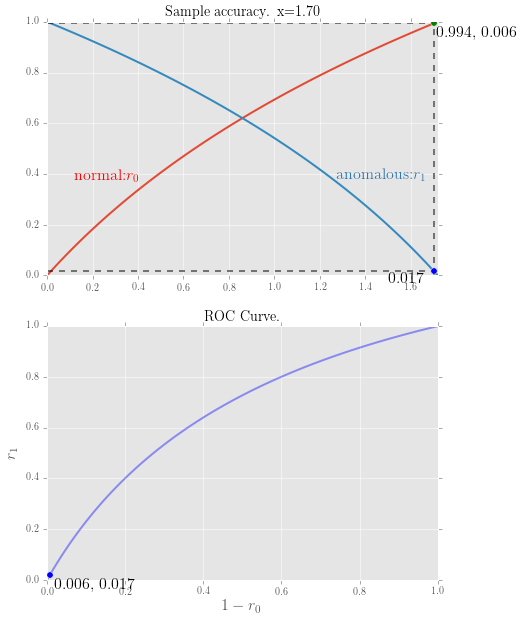

In [5]:
def animate(nframe):
    global num_frame
    sys.stdout.write(str(int(float(nframe)/num_frame*100)) + "%, ") 
    
    plt.clf()
    
    # xの最小値、最大値
    xmin = 0
    xmax = np.e -1

    # xの分割数
    sx = num_frame * 2

    # 現在位置
    pos = nframe * 2

    # x軸生成
    xx = np.linspace(xmin, xmax, sx)

    # 分布の準備
    cx1 = np.log(1+xx)
    cx2 = np.log(np.e -xx)

    # 1つ目のグラフ描画 -----------------------
    plt.subplot(211)
    plt.title("Sample accuracy. x={0:.2f}".format(xx[pos]))
    plt.xlim(xmin, xmax)
    plt.ylim(0,1)
    
    # 曲線の描画
    plt.plot(xx,cx1,linewidth=2)
    plt.plot(xx,cx2,linewidth=2)
    
    # 点と座標値の描画
    plt.scatter(xx[pos],cx1[pos], c="g", s=40, zorder=100)
    plt.text(xx[pos]+.01,cx1[pos]-.05,"{0:.3f}, {1:.3f}".format(cx1[pos], 1-cx1[pos]), size=16)
    plt.scatter(xx[pos],cx2[pos], c="b", s=40, zorder=100)
    plt.text(xx[pos]-.20,cx2[pos]-.05,"{0:.3f}".format(cx2[pos]), size=16)

    # 点線の描画
    plt.plot([xx[pos], xx[pos]], [0,1], "k--", alpha=.5, lw=2 )
    plt.plot([0, xx[pos]], [cx1[pos],cx1[pos]], "k--", alpha=.5, lw=2 )
    plt.plot([0, xx[pos]], [cx2[pos],cx2[pos]], "k--", alpha=.5, lw=2 )

    plt.text(.12, .37, r"normal:$r_0$", color="r", size=16)
    plt.text(1.27, .37, r"anomalous:$r_1$", color="#2F79B0", size=16)
    
    # 2つ目のグラフ描画 -----------------------
    plt.subplot(212)
    plt.title("ROC Curve.")
    plt.xlim(0,1)
    plt.ylim(0,1)
    
    # 曲線と点の描画
    plt.plot(1-cx1, cx2, linewidth=2, color="b", alpha=.4)
    plt.scatter(1-cx1[pos],cx2[pos], c="b", s=40, zorder=100)
    plt.text(1-cx1[pos]+.01,cx2[pos]-.05, "{0:.3f}, {1:.3f}".format(1-cx1[pos], cx2[pos]), size=16)

    plt.xlabel(r"$1-r_0$", size=16)
    plt.ylabel(r"$r_1$", size=16)

num_frame = 50
fig = plt.figure(figsize=(7,10))
anim = ani.FuncAnimation(fig, animate, frames=num_frame, blit=True)
anim.save('ROC_curve2.gif', writer='imagemagick', fps=3, dpi=64)